In [1]:
import pandas as pd
import numpy as np

In [2]:
# historical data is all historical truth < date
def predict(historical_data, date):
    idx = historical_data.shape[0]
    d0 = [] # historical values on this date
    d7 = [] # historical values on this date - 7
    for i in range(idx-365,0,-365):
        ndvi = historical_data.iloc[i]['ndvi_smoothed']
        d0.append(ndvi)
        ndvi = historical_data.iloc[i-7]['ndvi_smoothed']
        d7.append(ndvi)
    
    # what is the ndvi typicaly on this day and this day-7
    typical0 = sum(d0)/len(d0)
    typical7 = sum(d7)/len(d7)

    # what was ndvi yesterday? 
    yesterday = historical_data.iloc[idx-1]['ndvi_smoothed']
    # what was it 7 days ago?
    d7 = historical_data.iloc[idx-7]['ndvi_smoothed']

    # current trend
    slope = (yesterday - d7)/7
    # historically what has the trend been around now
    typical_slope = (typical0 - typical7)/7

    # gyess the change as the average of current trend and historical trend
    # then divide it by 3 instead of 2 to just temper things a bit
    delta = (slope + typical_slope)/3
    
    
    guess = yesterday + delta
    return guess

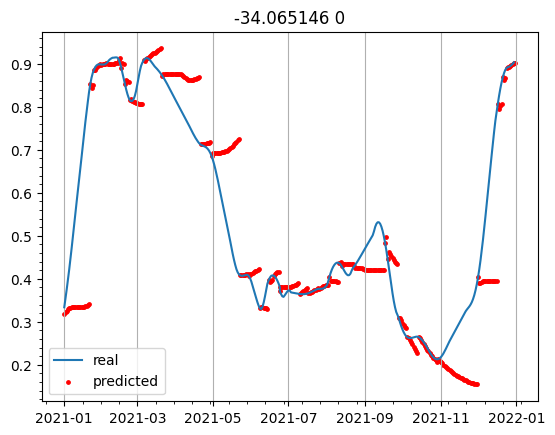

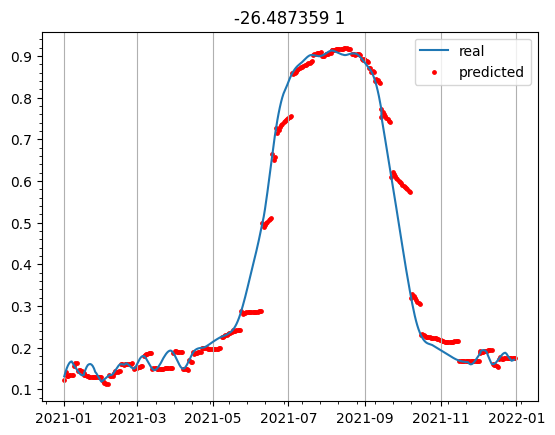

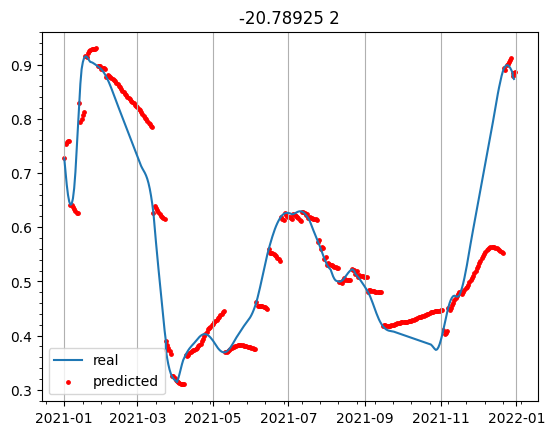

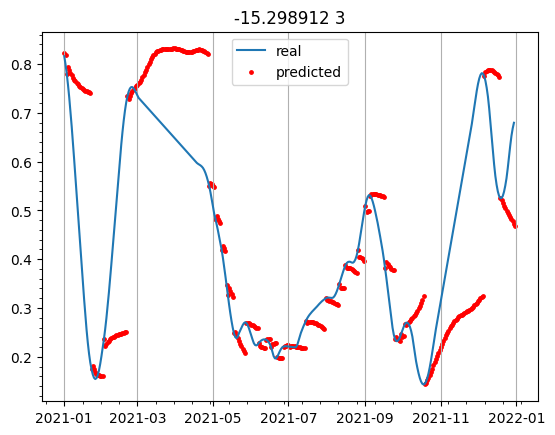

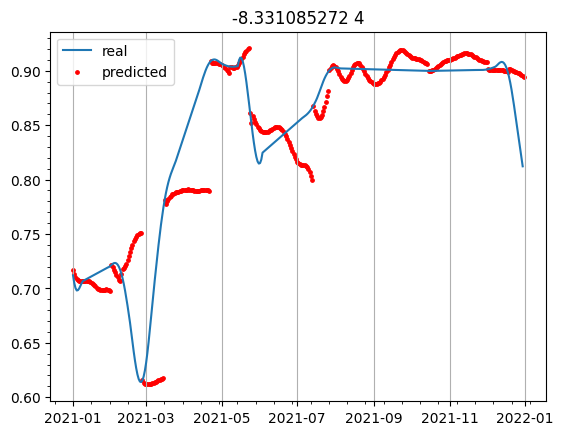

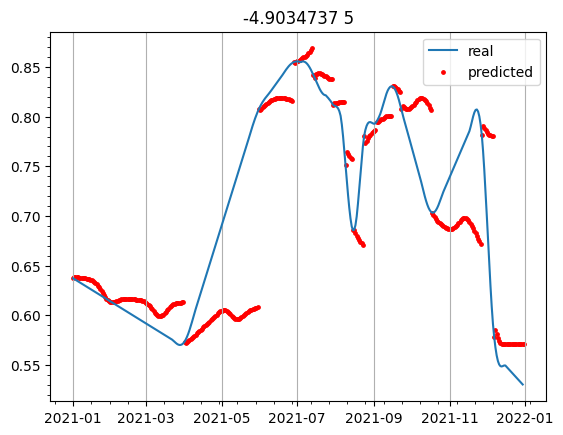

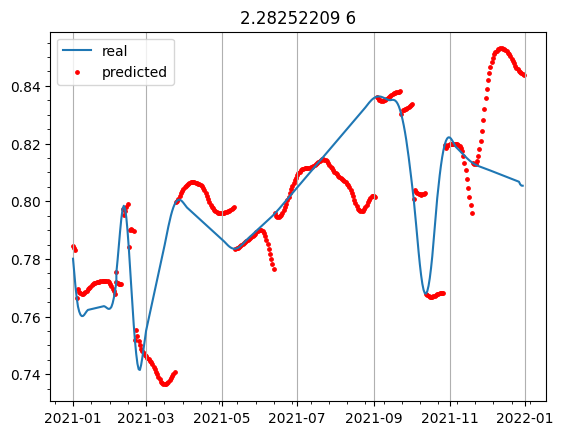

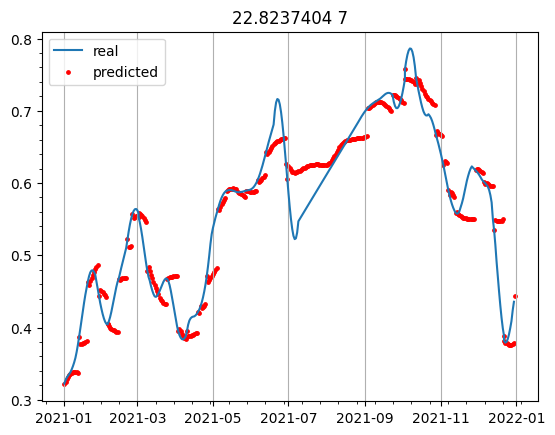

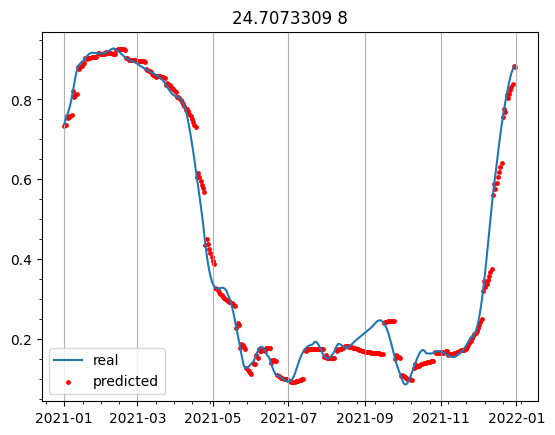

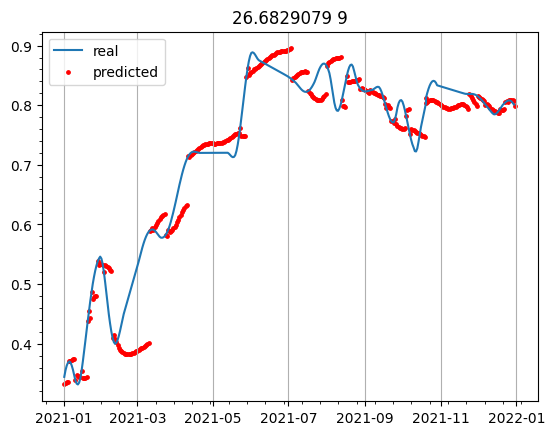

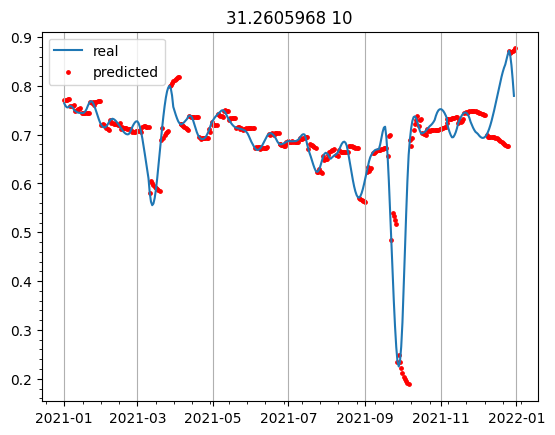

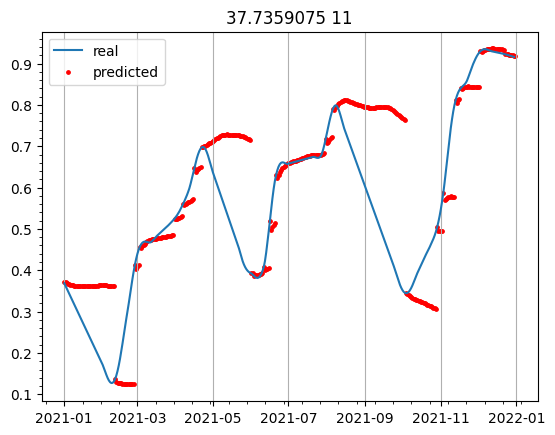

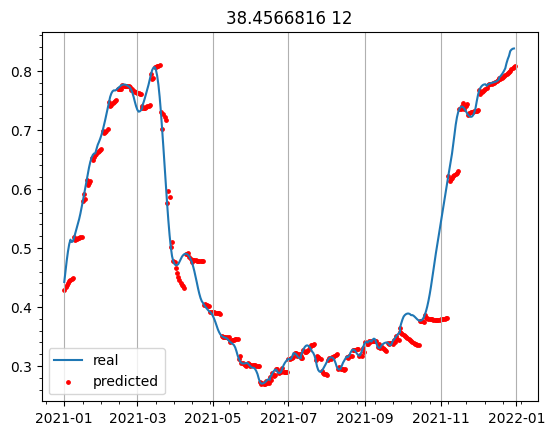

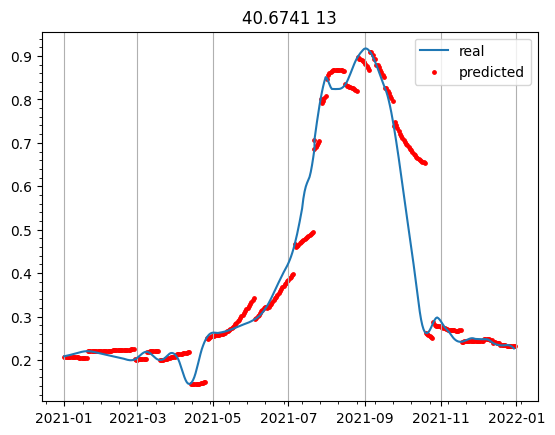

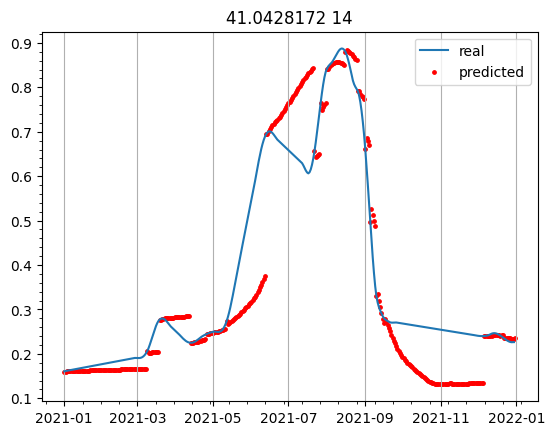

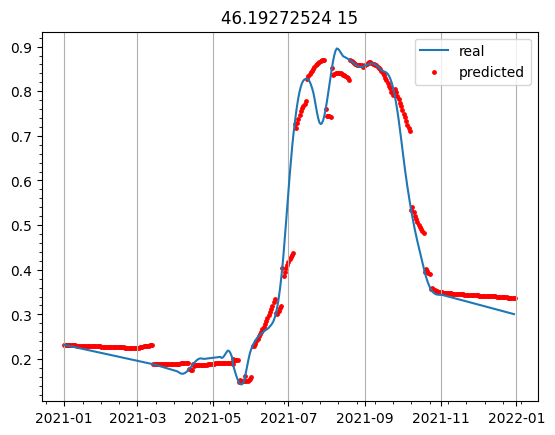

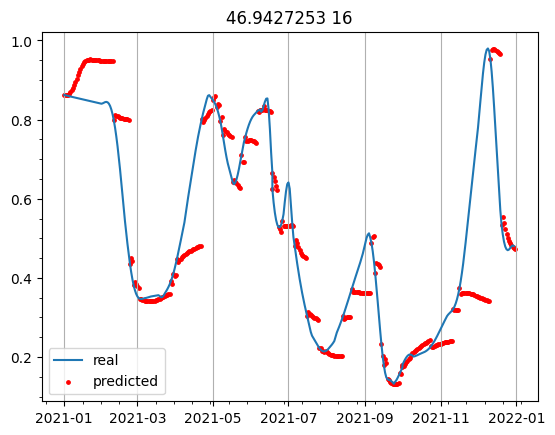

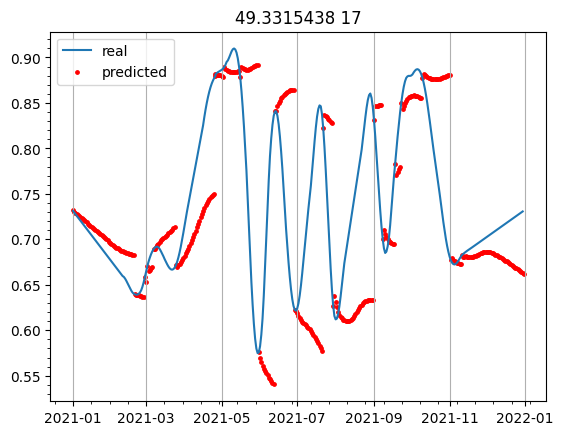

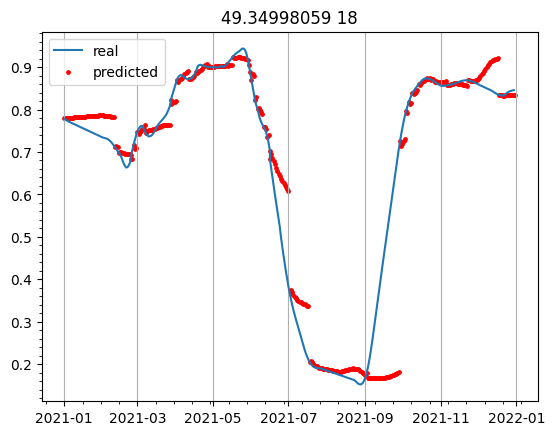

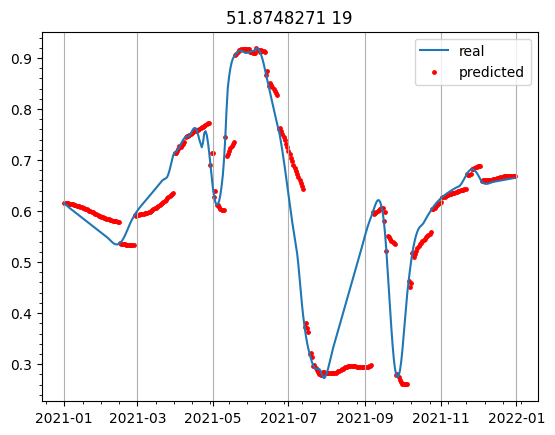

In [4]:
import matplotlib.pyplot as plt

def make_plot(this,pure,ds,de,nn):
    this1 = this[ds:de]
    pure1 = pure[(pure['time'] >= start_date) & (pure['time'] <= end_date)]
    plt.title(str(lats[where]) + ' ' + str(where))
    # plot this['ndvi_smoothed'] and nn['ndvi_smoothed'] with legends vs time
    plt.plot(this1['time'], this1['ndvi_smoothed'], label='real')
    plt.scatter(nn['time'], nn['ndvi_smoothed'], label='predicted',s=6,color='red')
    # plots s2l8['ndvi'] vs time
    # plt.scatter(pure1['time'], pure1['ndvi'], label='s2l8')
    # add vertical grid lines
    plt.grid(axis='x')
    # add minor vertical grid lines
    plt.minorticks_on()
    plt.legend()
    plt.show()

def extrapolate(pure,this,start_date,end_date):
    ds = this.loc[this['time'] == start_date].index.values[0] 
    de = this.loc[this['time'] == end_date].index.values[0]
    current = this[:ds]
    current = current.drop(['lat','ndvi'], axis=1)
    nn = pd.DataFrame()
    for i in range(ds,de+1):
        # get the ith row of this
        row = this.iloc[i]
        date = row['time']
        # check if this date exists in s2l8
        if date in pure['time'].values:
            # we have a real measurement
            x = {'time':date, 'ndvi_smoothed':row['ndvi_smoothed']}
            # pd.concatenate nn and x
            nn = pd.concat([nn, pd.DataFrame(x, index=[0])], ignore_index=True)
            current = this[:i]
            current = current.drop(['lat','ndvi'], axis=1)
        else:
            # we need to predict
            prediction = predict(current,date)
            # prediction = 1.
            # add prediction to nn
            x = {'time':date, 'ndvi_smoothed':prediction}
            nn = pd.concat([nn, pd.DataFrame(x, index=[0])], ignore_index=True)
            # update current_feature
            current = pd.concat([current, pd.DataFrame(x, index=[0])], ignore_index=True)
    make_plot(this,pure,ds,de,nn)

data = pd.read_parquet('data/training.parquet')
lats = data['lat'].unique()

# load s2l8.parquet
s2l8 = pd.read_parquet('data/s2l8.parquet')

# predict in 2021
start_date = '2021-01-01'
end_date = '2021-12-31'

for where in range(0,20):
    pure = s2l8[s2l8['lat'] == lats[where]]
    this = data[data['lat'] == lats[where]]
    extrapolate(pure,this,start_date,end_date)